# Modeling

In [ ]:
# loading library
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from prettytable import PrettyTable

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import log_loss

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
import xgboost as xgb
# import catboost as cb

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Flatten, Concatenate, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model

In [ ]:
# reference: https://machinelearningmastery.com/how-to-save-a-numpy-array-to-file-for-machine-learning/

X_train = np.load('drive/My Drive/KKBox/actual_train.npz')
y_train = np.load('drive/My Drive/KKBox/actual_train_labels.npz')
X_cv = np.load('drive/My Drive/KKBox/actual_cv.npz')
y_cv = np.load('drive/My Drive/KKBox/actual_cv_labels.npz')
test_data = np.load('drive/My Drive/KKBox/actual_test.npz')

In [ ]:
X_train = X_train['arr_0']
X_cv = X_cv['arr_0']
y_train = y_train['arr_0']
y_cv = y_cv['arr_0']
test_data = test_data['arr_0']

# getting shapes
print(X_train.shape, y_train.shape)
print(X_cv.shape, y_cv.shape)
print(test_data.shape)

(776768, 57) (776768,)
(194192, 57) (194192,)
(907471, 57)


In [ ]:
# loading columns
cols = np.load('../Prepare Data/columns.npz')
# converting numpy array to python list
cols = cols['arr_0'].tolist()
# removing first two cols 'msno' and 'is_churn'
cols = cols[2:]

## Logistic Regression

In [ ]:
# logistic regression model
lr_model = LogisticRegression()

params = {'C' : [0.0001,0.001,0.01,0.1,1,10,100]}

# Random search cv
rs_lr = RandomizedSearchCV(lr_model, param_distributions=params, verbose=10, n_jobs=-1)
rs_lr.fit(X_train, y_train)
# getting best parameters
rs_lr.best_params_

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   18.1s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   33.8s
[Parallel(n_jobs=-1)]: Done  24 out of  35 | elapsed:   53.3s remaining:   24.4s
[Parallel(n_jobs=-1)]: Done  28 out of  35 | elapsed:  1.1min remaining:   16.8s
[Parallel(n_jobs=-1)]: Done  32 out of  35 | elapsed:  1.2min remaining:    6.7s
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:  1.3min finished


{'C': 10}

In [ ]:
%%time

# fitting logistic regression model with best parameter values
lr_model = LogisticRegression(penalty='l2', tol=0.0001, C=10, solver='newton-cg', class_weight='balanced', n_jobs=-1)
lr_model.fit(X_train, y_train)

CPU times: user 200 ms, sys: 216 ms, total: 416 ms
Wall time: 6min 48s


LogisticRegression(C=10, class_weight='balanced', n_jobs=-1, solver='newton-cg')

In [ ]:
# Reference: https://machinelearningmastery.com/save-load-machine-learning-models-python-scikit-learn/#:~:text=Saving%20Your%20Model-,Save%20Your%20Model%20with%20pickle,it%20to%20make%20new%20predictions.
# saving the trained logistic regression ML model
filename = 'finalized_model_lr.sav'
joblib.dump(lr_model, filename)

['finalized_model_lr.sav']

### Using best model

In [ ]:
# loading the best model from disk
filename = 'finalized_model_lr.sav'
loaded_model = joblib.load(filename)

In [ ]:
# predicting probabilities for X_train
pred_train = loaded_model.predict_proba(X_train)
# getting probabilities corresponding to class label 1 only
pred_train = pred_train[:,1]
# calculating log loss
print('train log-loss: ', log_loss(y_train, pred_train))

# predicting probabilities for X_cv
pred_cv = loaded_model.predict_proba(X_cv)
# getting probabilities corresponding to class label 1 only
pred_cv = pred_cv[:,1]
# calculating log loss
print('cv log-loss: ', log_loss(y_cv, pred_cv))

train log-loss:  0.2874875903364252
cv log-loss:  0.2857579071007114


In [ ]:
# getting important features
imp_features = loaded_model.coef_
# converting 2-d numpy array to 1-d
imp_features = imp_features.flatten()
# sorting in descending order
imp_features = sorted(imp_features, reverse=True)
# taking top 10 most important features only
imp_features = imp_features[:10]

# printing them
for i, v in enumerate(imp_features):
    print('Feature: %0d, Score: %.5f' % (i,v))

Feature: 0, Score: 92.95470
Feature: 1, Score: 51.62558
Feature: 2, Score: 44.09034
Feature: 3, Score: 37.23306
Feature: 4, Score: 30.70314
Feature: 5, Score: 23.31642
Feature: 6, Score: 8.86896
Feature: 7, Score: 7.12494
Feature: 8, Score: 6.86370
Feature: 9, Score: 6.75550


In [ ]:
# predicting probabilities for test data
pred_test = loaded_model.predict_proba(test_data)
# getting probabilities corresponding to class label 1 only
pred_test = pred_test[:,1]
# printing them
pred_test

array([0.11424627, 0.02807819, 0.06450378, ..., 0.06407625, 0.04282128,
       0.0311506 ])

In [ ]:
# loading sample submission file
submit = pd.read_csv('../Data/sample_submission_v2.csv')
# dropping default labels
submit = submit.drop('is_churn', axis=1, inplace=False)
# getting head(top 5 rows)
submit.head()

,msno
0,4n+fXlyJvfQnTeKXTWT507Ll4JVYGrOC8LHCfwBmPE4=
1,aNmbC1GvFUxQyQUidCVmfbQ0YeCuwkPzEdQ0RwWyeZM=
2,rFC9eSG/tMuzpre6cwcMLZHEYM89xY02qcz7HL4//jc=
3,WZ59dLyrQcE7ft06MZ5dj40BnlYQY7PHgg/54+HaCSE=
4,aky/Iv8hMp1/V/yQHLtaVuEmmAxkB5GuasQZePJ7NU4=


In [ ]:
# multiplying 0.6 with each of the probabilities
submit['is_churn'] = pred_test * 0.6
# getting head(top 5 rows)
submit.head()

,msno,is_churn
0,4n+fXlyJvfQnTeKXTWT507Ll4JVYGrOC8LHCfwBmPE4=,0.068548
1,aNmbC1GvFUxQyQUidCVmfbQ0YeCuwkPzEdQ0RwWyeZM=,0.016847
2,rFC9eSG/tMuzpre6cwcMLZHEYM89xY02qcz7HL4//jc=,0.038702
3,WZ59dLyrQcE7ft06MZ5dj40BnlYQY7PHgg/54+HaCSE=,0.052784
4,aky/Iv8hMp1/V/yQHLtaVuEmmAxkB5GuasQZePJ7NU4=,0.051908


In [ ]:
# saving csv to the disk
submit.to_csv('submission_lr075.csv', index=False)

**By using this Logistic Regression model, I got 0.15197 as public leaderboard test log-loss, and 0.15148 as private leaderboard test log-loss.**

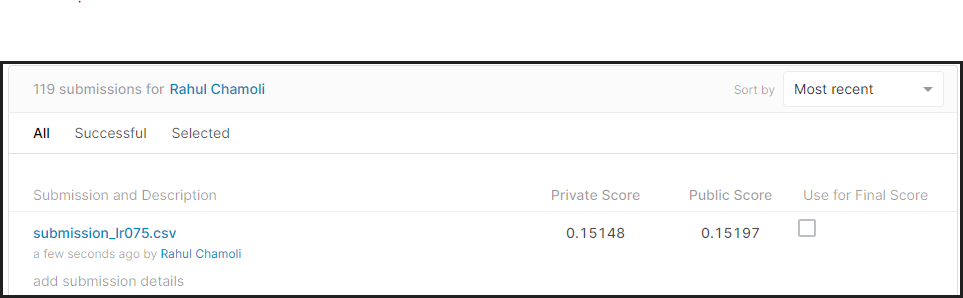

## Decision tree

In [ ]:
%%time

# decision tree classifier model
dtc_model = DecisionTreeClassifier()

params = {'max_depth' : [2,3,5,7,10,15],
          'min_samples_split' : [2,3,5,7,10],
          'min_samples_leaf' : [1,2,3],
          'criterion' : ['gini', 'entropy'],
          'splitter' : ['best', 'random']}

# Random search cv
rs_dtc = RandomizedSearchCV(dtc_model, param_distributions=params, verbose=10, n_jobs=-1)
rs_dtc.fit(X_train, y_train)
# getting best parameters
rs_dtc.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   25.1s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   34.0s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:   40.0s remaining:    8.8s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:   48.4s remaining:    3.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   49.9s finished


CPU times: user 8.9 s, sys: 356 ms, total: 9.26 s
Wall time: 58.8 s


{'splitter': 'best',
 'min_samples_split': 3,
 'min_samples_leaf': 1,
 'max_depth': 5,
 'criterion': 'gini'}

In [ ]:
%%time

# training a decision tree classifier model with best parameters
dtc_model = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=5, min_samples_split=3, min_samples_leaf=1)
dtc_model.fit(X_train, y_train)

CPU times: user 8.62 s, sys: 52 ms, total: 8.68 s
Wall time: 8.67 s


DecisionTreeClassifier(max_depth=5, min_samples_split=3)

In [ ]:
# https://machinelearningmastery.com/save-load-machine-learning-models-python-scikit-learn/#:~:text=Saving%20Your%20Model-,Save%20Your%20Model%20with%20pickle,it%20to%20make%20new%20predictions.
# saving the decision tree classifier model
filename = 'finalized_model_dtc.sav'
joblib.dump(dtc_model, filename)

['finalized_model_dtc.sav']

### Using best model

In [ ]:
# loading the best decision tree classifier model from disk
filename = 'finalized_model_dtc.sav'
loaded_model = joblib.load(filename)

In [ ]:
# predicting probabilities for X_train
pred_train = loaded_model.predict_proba(X_train)
# getting probabilities corresponding to class label 1 only
pred_train = pred_train[:,1]
# calculating log loss
print('train log-loss: ', log_loss(y_train, pred_train))

# predicting probabilities for X_cv
pred_cv = loaded_model.predict_proba(X_cv)
# getting probabilities corresponding to class label 1 only
pred_cv = pred_cv[:,1]
# calculating log loss
print('cv log-loss: ', log_loss(y_cv, pred_cv))

train log-loss:  0.10728510049668556
cv log-loss:  0.1084942996632845


In [ ]:
# getting important features
imp_features = loaded_model.feature_importances_
# sorting them in descending order
imp_features = sorted(imp_features, reverse=True)
# getting top 10 important features
imp_features = imp_features[:10]

# printing them
for i, v in enumerate(imp_features):
    print('Feature: %0d, Score: %.5f' % (i,v))

Feature: 0, Score: 0.49952
Feature: 1, Score: 0.33384
Feature: 2, Score: 0.04993
Feature: 3, Score: 0.04481
Feature: 4, Score: 0.02990
Feature: 5, Score: 0.02616
Feature: 6, Score: 0.01147
Feature: 7, Score: 0.00132
Feature: 8, Score: 0.00102
Feature: 9, Score: 0.00085


In [ ]:
# calcuating probabilities for test set
pred_test = loaded_model.predict_proba(test_data)
# getting probabilities corresponding to class label 1 only
pred_test = pred_test[:,1]
# pringing them
pred_test

array([0.01159075, 0.01159075, 0.01159075, ..., 0.01159075, 0.01159075,
       0.01159075])

In [ ]:
# loading sample submission file
submit = pd.read_csv('../Data/sample_submission_v2.csv')
# dropping default class labels
submit = submit.drop('is_churn', axis=1, inplace=False)
# getting head(top 5 rows)
submit.head()

,msno
0,4n+fXlyJvfQnTeKXTWT507Ll4JVYGrOC8LHCfwBmPE4=
1,aNmbC1GvFUxQyQUidCVmfbQ0YeCuwkPzEdQ0RwWyeZM=
2,rFC9eSG/tMuzpre6cwcMLZHEYM89xY02qcz7HL4//jc=
3,WZ59dLyrQcE7ft06MZ5dj40BnlYQY7PHgg/54+HaCSE=
4,aky/Iv8hMp1/V/yQHLtaVuEmmAxkB5GuasQZePJ7NU4=


In [ ]:
# multiplying 0.6 with class labels, and assigning them to new feature 'is_churn'
submit['is_churn'] = pred_test * 0.6
# getting head(top 5 rows)
submit.head()

,msno,is_churn
0,4n+fXlyJvfQnTeKXTWT507Ll4JVYGrOC8LHCfwBmPE4=,0.006954
1,aNmbC1GvFUxQyQUidCVmfbQ0YeCuwkPzEdQ0RwWyeZM=,0.006954
2,rFC9eSG/tMuzpre6cwcMLZHEYM89xY02qcz7HL4//jc=,0.006954
3,WZ59dLyrQcE7ft06MZ5dj40BnlYQY7PHgg/54+HaCSE=,0.006954
4,aky/Iv8hMp1/V/yQHLtaVuEmmAxkB5GuasQZePJ7NU4=,0.006954


In [ ]:
# saving csv file to the disk
submit.to_csv('submission_dtc075.csv', index=False)

**By using this Decision tree model, I got 0.15749 on public leaderboard as test log-loss, and 0.15624 on private leaderboard as test log-loss.**

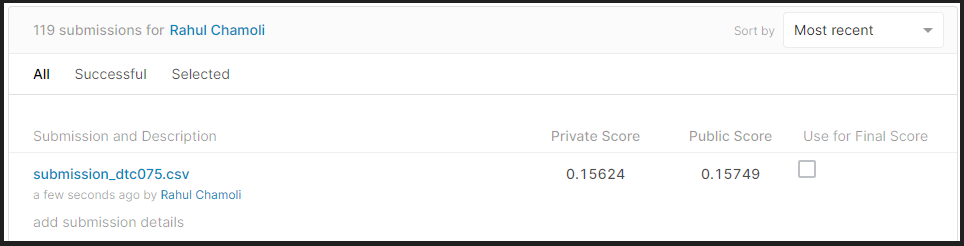

## Random Forest

In [ ]:
# Random forest classifier model
rf_model = RandomForestClassifier()

params = {'n_estimators' : [100,200,500,1000,2000],
          'max_features' : ['auto', 'sqrt'],
          'max_depth' : [2,3,5,10,15],
          'min_samples_split' : [2,3,5,7,10],
          'min_samples_leaf' : [1,2,3],
          'bootstrap' : [True, False]}

# Random search cv
rs_rf = RandomizedSearchCV(rf_model, param_distributions=params, verbose=50, n_jobs=-1)
rs_rf.fit(X_train, y_train)
# getting best parameters
rs_rf.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  8.7min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed: 18.2min
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed: 19.2min
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed: 19.3min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed: 27.

{'n_estimators': 500,
 'min_samples_split': 3,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 15,
 'bootstrap': False}

In [ ]:
%%time

# training the random forest classifier for best hyper parameters
rf_model = RandomForestClassifier(n_estimators=500, criterion='gini', max_depth=15, min_samples_split=3, min_samples_leaf=2, max_features='sqrt', bootstrap=False, n_jobs=-1)
rf_model.fit(X_train, y_train)

CPU times: user 41min 3s, sys: 604 ms, total: 41min 3s
Wall time: 5min 10s


RandomForestClassifier(bootstrap=False, max_depth=15, max_features='sqrt',
                       min_samples_leaf=2, min_samples_split=3,
                       n_estimators=500, n_jobs=-1)

In [ ]:
# https://machinelearningmastery.com/save-load-machine-learning-models-python-scikit-learn/#:~:text=Saving%20Your%20Model-,Save%20Your%20Model%20with%20pickle,it%20to%20make%20new%20predictions.
# saving best random forest classifier model
filename = 'finalized_model_rfc.sav'
joblib.dump(rf_model, filename)

['finalized_model_rfc.sav']

### Using best model

In [ ]:
# loading the best random forst classifier model from disk
filename = 'finalized_model_rfc.sav'
loaded_model = joblib.load(filename)

In [ ]:
# predicting probabilities for X_train
pred_train = loaded_model.predict_proba(X_train)
# getting probabilities corresponding to class label 1 only
pred_train = pred_train[:,1]
# calculating log loss
print('train log-loss: ', log_loss(y_train, pred_train))

# predicting probabilities for X_cv
pred_cv = loaded_model.predict_proba(X_cv)
# getting probabilities corresponding to class label 1 only
pred_cv = pred_cv[:,1]
# calculating log loss
print('cv log-loss: ', log_loss(y_cv, pred_cv))

train log-loss:  0.06070016596494737
cv log-loss:  0.07197515990426165


In [ ]:
# getting important features
imp_features = loaded_model.feature_importances_
# sorting them in descending order
imp_features = sorted(imp_features, reverse=True)
# taking top 10 most important features
imp_features = imp_features[:10]

# printing them
for i, v in enumerate(imp_features):
    print('Feature: %0d, Score: %.5f' % (i,v))

Feature: 0, Score: 0.21298
Feature: 1, Score: 0.20987
Feature: 2, Score: 0.12169
Feature: 3, Score: 0.11463
Feature: 4, Score: 0.06533
Feature: 5, Score: 0.03366
Feature: 6, Score: 0.02537
Feature: 7, Score: 0.02059
Feature: 8, Score: 0.01800
Feature: 9, Score: 0.01666


In [ ]:
# calculating probabilites for test set
pred_test = loaded_model.predict_proba(test_data)
# getting probabilities corresponding to class 1 only
pred_test = pred_test[:,1]
#printing them
pred_test

array([0.13148475, 0.1716275 , 0.08086735, ..., 0.11879872, 0.12211887,
       0.09695482])

In [ ]:
# loading sample submission file
submit = pd.read_csv('../Data/sample_submission_v2.csv')
# dropping default class labels
submit = submit.drop('is_churn', axis=1, inplace=False)
# getting head(top 5 rows)
submit.head()

,msno
0,4n+fXlyJvfQnTeKXTWT507Ll4JVYGrOC8LHCfwBmPE4=
1,aNmbC1GvFUxQyQUidCVmfbQ0YeCuwkPzEdQ0RwWyeZM=
2,rFC9eSG/tMuzpre6cwcMLZHEYM89xY02qcz7HL4//jc=
3,WZ59dLyrQcE7ft06MZ5dj40BnlYQY7PHgg/54+HaCSE=
4,aky/Iv8hMp1/V/yQHLtaVuEmmAxkB5GuasQZePJ7NU4=


In [ ]:
# multiplying test probabilities with 0.6
submit['is_churn'] = pred_test * 0.6
# getting head(top 5 rows)
submit.head()

,msno,is_churn
0,4n+fXlyJvfQnTeKXTWT507Ll4JVYGrOC8LHCfwBmPE4=,0.078891
1,aNmbC1GvFUxQyQUidCVmfbQ0YeCuwkPzEdQ0RwWyeZM=,0.102977
2,rFC9eSG/tMuzpre6cwcMLZHEYM89xY02qcz7HL4//jc=,0.048520
3,WZ59dLyrQcE7ft06MZ5dj40BnlYQY7PHgg/54+HaCSE=,0.086388
4,aky/Iv8hMp1/V/yQHLtaVuEmmAxkB5GuasQZePJ7NU4=,0.083507


In [ ]:
# saving best model to the disk
submit.to_csv('submission_rfc075.csv', index=False)

**By using this Random Forest model, I got 0.15946 on public leaderboard as test log-loss, and 0.15910 on private leaderboard as test log-loss.**

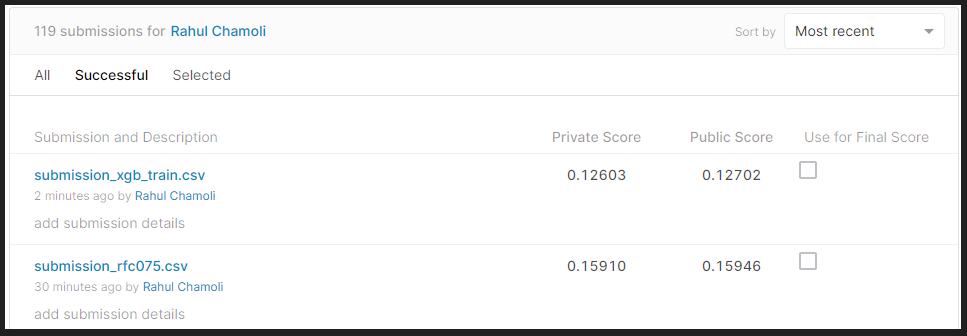

## XGBoost

In [ ]:
# creating DMatrix for train, cv, and test
train = xgb.DMatrix(X_train, label=y_train, feature_names=cols, nthread=-1)
cv = xgb.DMatrix(X_cv, label=y_cv, feature_names=cols, nthread=-1)
test = xgb.DMatrix(test_data, feature_names=cols, nthread=-1)

In [ ]:
# setting parameters
params = {'objective' : 'binary:logistic',
          'eval_metric' : 'logloss'}

In [ ]:
%%time

# train the xgboost model
xgb_model = xgb.train(params, train, 12, verbose_eval=True)

CPU times: user 58.7 s, sys: 372 ms, total: 59 s
Wall time: 7.39 s


In [ ]:
# saving model
xgb_model.save_model('finalized_model_xgb_train.sav')

### Using best model 

In [ ]:
# loading model
xgb_model = xgb.Booster(model_file='finalized_model_xgb_train.sav')

In [ ]:
# predicting probabilities for train data
pred_train = xgb_model.predict(train)
# calculating log-loss
log_loss(y_train, pred_train)

0.07607863581526318

In [ ]:
# predicting probabilities for cv data
pred_cv = xgb_model.predict(cv)
# calculating log-loss
log_loss(y_cv, pred_cv)

0.07726354674937265

Text(0.5, 1.0, 'Feature importance for xgboost model')

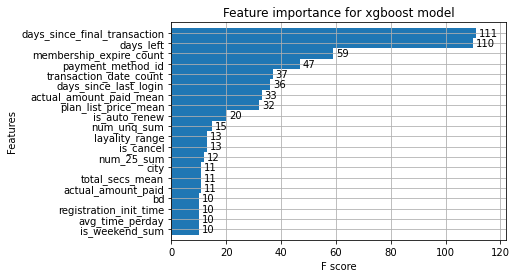

In [ ]:
# plotting important features
xgb.plot_importance(xgb_model, max_num_features=20, height=1)
plt.title('Feature importance for xgboost model')

In [ ]:
# predicting probabilities for test data
pred_test = xgb_model.predict(test)
# predicted prbabilities for test data
pred_test

array([0.01339018, 0.02584306, 0.01339018, ..., 0.01339018, 0.01772232,
       0.01339018], dtype=float32)

In [ ]:
# loading sample submission file
submit = pd.read_csv('../Data/sample_submission_v2.csv')
# dropping 'is_churn' feature
submit = submit.drop('is_churn', axis=1, inplace=False)
# getting head
submit.head()

,msno
0,4n+fXlyJvfQnTeKXTWT507Ll4JVYGrOC8LHCfwBmPE4=
1,aNmbC1GvFUxQyQUidCVmfbQ0YeCuwkPzEdQ0RwWyeZM=
2,rFC9eSG/tMuzpre6cwcMLZHEYM89xY02qcz7HL4//jc=
3,WZ59dLyrQcE7ft06MZ5dj40BnlYQY7PHgg/54+HaCSE=
4,aky/Iv8hMp1/V/yQHLtaVuEmmAxkB5GuasQZePJ7NU4=


In [ ]:
# multiplying 0.6 with probabilities
submit['is_churn'] = pred_test * 0.6
# getting head(top 5 rows)
submit.head()

,msno,is_churn
0,4n+fXlyJvfQnTeKXTWT507Ll4JVYGrOC8LHCfwBmPE4=,0.008034
1,aNmbC1GvFUxQyQUidCVmfbQ0YeCuwkPzEdQ0RwWyeZM=,0.015506
2,rFC9eSG/tMuzpre6cwcMLZHEYM89xY02qcz7HL4//jc=,0.008034
3,WZ59dLyrQcE7ft06MZ5dj40BnlYQY7PHgg/54+HaCSE=,0.008034
4,aky/Iv8hMp1/V/yQHLtaVuEmmAxkB5GuasQZePJ7NU4=,0.010633


In [ ]:
# csv saving
submit.to_csv('submission_xgb_train.csv', index=False)

**By using this xgboost train model I got 0.12702 on public leaderboard as test log-loss and 0.12603 on private leaderboard as test log-loss.**

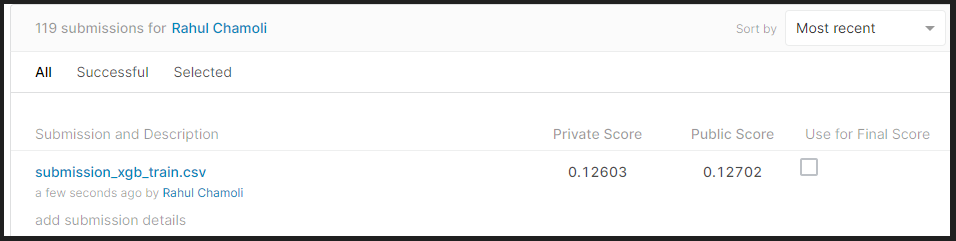

## LigntGBM

In [ ]:
# setting parameters
param = {'objective' : 'binary', 
         'metric' : 'binary-logloss',
         'num_leaves' : 31,
         'boosting' : 'dart'}

# creating Dataset for train and cross validation data
train = lgb.Dataset(X_train, label=y_train, feature_name=cols)
cv = lgb.Dataset(X_cv, label=y_cv, feature_name=cols)

In [ ]:
%%time

# train lgb model
lgb_model = lgb.train(param, train, num_boost_round=20, valid_sets=cv)

[LightGBM] [Info] Number of positive: 69880, number of negative: 706888
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.043239 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8161
[LightGBM] [Info] Number of data points in the train set: 776768, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.089963 -> initscore=-2.314093
[LightGBM] [Info] Start training from score -2.314093
CPU times: user 16 s, sys: 328 ms, total: 16.3 s
Wall time: 2.35 s


In [ ]:
# saving best model
lgb_model.save_model('finalized_model_lgb_train_2.sav')

### Using best model

In [ ]:
# loading saved model
lgb_model = lgb.Booster(model_file='finalized_model_lgb_train_2.sav')

In [ ]:
# predicting probabilities for train data
y_pred = lgb_model.predict(X_train)
# calculating log-loss for train data
print(log_loss(y_train, y_pred ))

0.08405046474697057


In [ ]:
# predicting probabilities for cv data
y_pred_cv = lgb_model.predict(X_cv)
# calculating log-loss for cv data
print(log_loss(y_cv, y_pred_cv))

0.08433756840455721


In [ ]:
# predicting probabilities for test data
y_pred_test = lgb_model.predict(test_data)
# probabilities for test data
y_pred_test

array([0.01719102, 0.01942716, 0.01719102, ..., 0.01719102, 0.01942716,
       0.01719102])

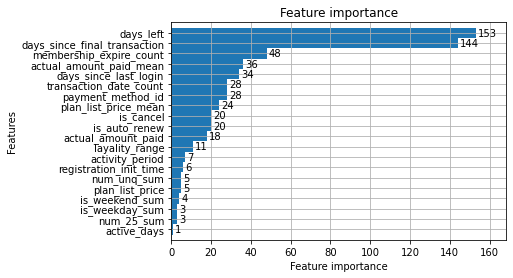

In [ ]:
# plotting important features
lgb.plot_importance(lgb_model,max_num_features=20,height=1)

In [ ]:
# loading sample submission file
submit = pd.read_csv('../Data/sample_submission_v2.csv')
# dropping 'is_churn' feature
submit = submit.drop('is_churn', axis=1, inplace=False)
# getting head(top 5 rows)
submit.head()

,msno
0,4n+fXlyJvfQnTeKXTWT507Ll4JVYGrOC8LHCfwBmPE4=
1,aNmbC1GvFUxQyQUidCVmfbQ0YeCuwkPzEdQ0RwWyeZM=
2,rFC9eSG/tMuzpre6cwcMLZHEYM89xY02qcz7HL4//jc=
3,WZ59dLyrQcE7ft06MZ5dj40BnlYQY7PHgg/54+HaCSE=
4,aky/Iv8hMp1/V/yQHLtaVuEmmAxkB5GuasQZePJ7NU4=


In [ ]:
# multiplying probabilities with 0.6
submit['is_churn'] = y_pred_test * 0.60
# getting head(top 5 rows)
submit.head()

,msno,is_churn
0,4n+fXlyJvfQnTeKXTWT507Ll4JVYGrOC8LHCfwBmPE4=,0.010315
1,aNmbC1GvFUxQyQUidCVmfbQ0YeCuwkPzEdQ0RwWyeZM=,0.011656
2,rFC9eSG/tMuzpre6cwcMLZHEYM89xY02qcz7HL4//jc=,0.010315
3,WZ59dLyrQcE7ft06MZ5dj40BnlYQY7PHgg/54+HaCSE=,0.010315
4,aky/Iv8hMp1/V/yQHLtaVuEmmAxkB5GuasQZePJ7NU4=,0.011612


In [ ]:
# csv saving
submit.to_csv('submission_lgb_train.csv', index=False)

**By using this lightGBM model I got 0.12697 on public leaderboard as test log-loss, and 0.12600 on private leaderboard as test log-loss.**

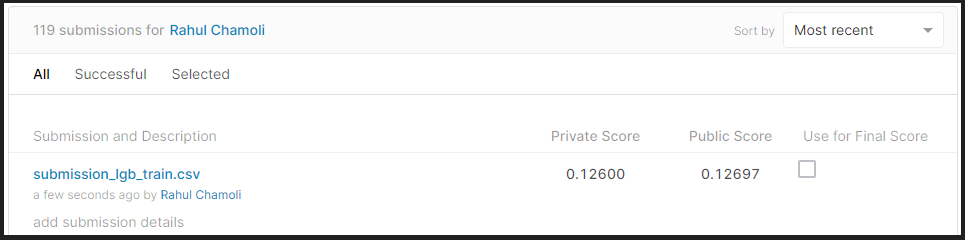

## CatBoost

In [ ]:
# creating Pool for train, test and cv
train = cb.Pool(X_train, label=y_train, feature_names=cols, thread_count=-1)
cv = cb.Pool(X_cv, label=y_cv, feature_names=cols, thread_count=-1)
test = cb.Pool(test_data, feature_names=cols, thread_count=-1)

In [ ]:
# setting parameters
params = {'loss_function' : 'Logloss',
          'eval_metric' : 'Logloss'}

# train the catboost model
cbc_model = cb.train(train, params, num_boost_round=3, verbose=True, eval_set=cv)

Learning rate set to 0.5
0:	learn: 0.1957306	test: 0.1960365	best: 0.1960365 (0)	total: 141ms	remaining: 283ms
1:	learn: 0.1175089	test: 0.1181246	best: 0.1181246 (1)	total: 220ms	remaining: 110ms
2:	learn: 0.1019970	test: 0.1025521	best: 0.1025521 (2)	total: 292ms	remaining: 0us

bestTest = 0.1025521466
bestIteration = 2



In [ ]:
# https://machinelearningmastery.com/save-load-machine-learning-models-python-scikit-learn/#:~:text=Saving%20Your%20Model-,Save%20Your%20Model%20with%20pickle,it%20to%20make%20new%20predictions.
filename = 'finalized_model_cbc_train.sav'
joblib.dump(cbc_model, filename)

['finalized_model_cbc_train.sav']

### Using best model

In [ ]:
# loading the best random forst classifier model from disk
filename = 'finalized_model_cbc_train.sav'
loaded_model = joblib.load(filename)

In [ ]:
# predicting probabilities for train data
pred_train = loaded_model.predict(train, prediction_type='Probability')
# getting probabilities belong to class 1 only
pred_train = pred_train[:,1]
# calculating log-loss
log_loss(y_train, pred_train)

0.10199699583768657

In [ ]:
# predicting probabilities for cv data
pred_cv = loaded_model.predict(cv, prediction_type='Probability')
# getting probabilities belong to class 1 only
pred_cv = pred_cv[:,1]
# calculating log-loss
log_loss(y_cv, pred_cv)

0.10255214658116538

In [ ]:
# predicting probabilities for test data
pred_test = loaded_model.predict(test_data, prediction_type='Probability')
# getting probabilities belong to class 1 only
pred_test = pred_test[:,1]
# probabilities for test data
pred_test

array([0.01213378, 0.03909202, 0.01413892, ..., 0.01215849, 0.03165161,
       0.01413892])

In [ ]:
# loading sample submission file
submit = pd.read_csv('../Data/sample_submission_v2.csv')
# dropping 'is_churn' feature from the dataset
submit = submit.drop('is_churn', axis=1, inplace=False)
# getting head(top 5) rows
submit.head()

,msno
0,4n+fXlyJvfQnTeKXTWT507Ll4JVYGrOC8LHCfwBmPE4=
1,aNmbC1GvFUxQyQUidCVmfbQ0YeCuwkPzEdQ0RwWyeZM=
2,rFC9eSG/tMuzpre6cwcMLZHEYM89xY02qcz7HL4//jc=
3,WZ59dLyrQcE7ft06MZ5dj40BnlYQY7PHgg/54+HaCSE=
4,aky/Iv8hMp1/V/yQHLtaVuEmmAxkB5GuasQZePJ7NU4=


In [ ]:
# multiplying probabilities with 0.6
submit['is_churn'] = pred_test * 0.6
# getting head(top 5 rows)
submit.head()

,msno,is_churn
0,4n+fXlyJvfQnTeKXTWT507Ll4JVYGrOC8LHCfwBmPE4=,0.007280
1,aNmbC1GvFUxQyQUidCVmfbQ0YeCuwkPzEdQ0RwWyeZM=,0.023455
2,rFC9eSG/tMuzpre6cwcMLZHEYM89xY02qcz7HL4//jc=,0.008483
3,WZ59dLyrQcE7ft06MZ5dj40BnlYQY7PHgg/54+HaCSE=,0.007280
4,aky/Iv8hMp1/V/yQHLtaVuEmmAxkB5GuasQZePJ7NU4=,0.013275


In [ ]:
# saving csv
submit.to_csv('submission_cbc_train.csv', index=False)

**By using this model I got 0.13111 on public leaderboard as test log-loss, and 0.13013 on private leaderboard as test log-loss.**

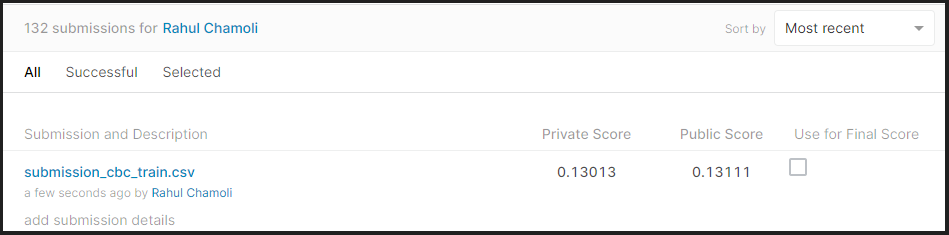

## Neural Network Model

In [ ]:
# getting device information
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 15098055429328670261, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 8063881950973144564
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 8261380313957092714
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14640891840
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 13526097998939145098
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"]

In [ ]:
init = tf.keras.initializers.HeUniform()
regular = tf.keras.regularizers.l2(l2=0.01)

# Input layer
input_layer = Input(shape=(57,))

# Dense hidden layer 1
layer1 = Dense(64, activation='relu', kernel_initializer=init, kernel_regularizer=regular)(input_layer)

# Batch Normalization layer 1
b_norm1 = BatchNormalization()(layer1)

# Dropout layer 1
drop1 = Dropout(rate=0.5)(b_norm1)

# Dense hidden layer 2
layer2 = Dense(32, activation='relu', kernel_initializer=init, kernel_regularizer=regular)(drop1)

# Batch Normalization layer 2
b_norm2 = BatchNormalization()(layer2)

# Dropout layer 2
drop2 = Dropout(rate=0.5)(b_norm2)

# Dense hidden layer 3
layer3 = Dense(16, activation='relu', kernel_initializer=init, kernel_regularizer=regular)(drop2)

# Batch Normalization layer 3
b_norm3 = BatchNormalization()(layer3)

# Dropout layer 3
drop3 = Dropout(rate=0.5)(b_norm3)

# Output layer
output_layer = Dense(1, activation='sigmoid', kernel_initializer=tf.keras.initializers.glorot_uniform(), kernel_regularizer=regular)(drop3)

# Creating a model
model = Model(inputs=input_layer, outputs=output_layer)

# summary
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 57)]              0         
_________________________________________________________________
dense (Dense)                (None, 64)                3712      
_________________________________________________________________
batch_normalization (BatchNo (None, 64)                256       
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32)                128       
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)               

In [ ]:
# Compile model
adam = tf.keras.optimizers.Adam()

model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

In [ ]:
filepath = "drive/My Drive/KKBox/best_model.h5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

es = EarlyStopping(monitor='val_loss', patience=3, mode='min', verbose=1, restore_best_weights=True)

cb = [es, checkpoint]

In [ ]:
# Fit the model
history = model.fit(X_train, y_train, epochs=10, batch_size=256, validation_data=(X_cv, y_cv), verbose=1, callbacks=cb)

Epoch 1/10
3026/3035 [============================>.] - ETA: 0s - loss: 0.3991 - accuracy: 0.9202
Epoch 00001: val_loss improved from inf to 0.33759, saving model to drive/My Drive/KKBox/best_model.h5
3035/3035 [==============================] - 15s 5ms/step - loss: 0.3985 - accuracy: 0.9203 - val_loss: 0.3376 - val_accuracy: 0.9324
Epoch 2/10
3032/3035 [============================>.] - ETA: 0s - loss: 0.1625 - accuracy: 0.9532
Epoch 00002: val_loss improved from 0.33759 to 0.22080, saving model to drive/My Drive/KKBox/best_model.h5
3035/3035 [==============================] - 15s 5ms/step - loss: 0.1625 - accuracy: 0.9532 - val_loss: 0.2208 - val_accuracy: 0.9493
Epoch 3/10
3035/3035 [==============================] - ETA: 0s - loss: 0.1549 - accuracy: 0.9530
Epoch 00003: val_loss did not improve from 0.22080
3035/3035 [==============================] - 15s 5ms/step - loss: 0.1549 - accuracy: 0.9530 - val_loss: 0.7959 - val_accuracy: 0.3293
Epoch 4/10
3034/3035 [=====================

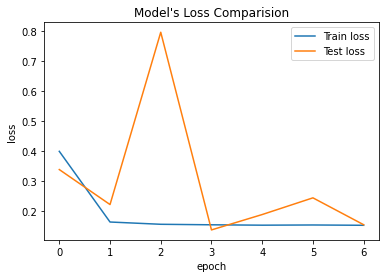

In [ ]:
# loss comparison plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model's Loss Comparision")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Train loss', 'Test loss'], loc='upper right')
plt.show()

In [ ]:
# loading best model from disk
model = load_model('drive/My Drive/KKBox/best_model.h5')

# predicting probabilities for test data
pred_test = model.predict(test_data)
# converting 2d array to 1d using flatten
pred_test = pred_test.flatten()
# getting probabilities
pred_test

array([0.02549033, 0.01600544, 0.01716729, ..., 0.02102195, 0.0169536 ,
       0.01507807], dtype=float32)

In [ ]:
# loading sample submission file
submit = pd.read_csv('drive/My Drive/KKBox/sample_submission_v2.csv')
# dropping default class labels
submit = submit.drop('is_churn', axis=1, inplace=False)
# getting head(top 5 rows)
submit.head()

,msno
0,4n+fXlyJvfQnTeKXTWT507Ll4JVYGrOC8LHCfwBmPE4=
1,aNmbC1GvFUxQyQUidCVmfbQ0YeCuwkPzEdQ0RwWyeZM=
2,rFC9eSG/tMuzpre6cwcMLZHEYM89xY02qcz7HL4//jc=
3,WZ59dLyrQcE7ft06MZ5dj40BnlYQY7PHgg/54+HaCSE=
4,aky/Iv8hMp1/V/yQHLtaVuEmmAxkB5GuasQZePJ7NU4=


In [ ]:
# multiplying 0.6 with class labels, and assigning them to new feature 'is_churn'
submit['is_churn'] = pred_test * 0.6
# getting head(top 5 rows)
submit.head()

,msno,is_churn
0,4n+fXlyJvfQnTeKXTWT507Ll4JVYGrOC8LHCfwBmPE4=,0.015294
1,aNmbC1GvFUxQyQUidCVmfbQ0YeCuwkPzEdQ0RwWyeZM=,0.009603
2,rFC9eSG/tMuzpre6cwcMLZHEYM89xY02qcz7HL4//jc=,0.010300
3,WZ59dLyrQcE7ft06MZ5dj40BnlYQY7PHgg/54+HaCSE=,0.013388
4,aky/Iv8hMp1/V/yQHLtaVuEmmAxkB5GuasQZePJ7NU4=,0.020817


In [ ]:
# saving csv file to the disk
submit.to_csv('drive/My Drive/KKBox/submission_ffnn06.csv', index=False)

**By using this model I got 0.12291 as public leaderboard test log-loss, and 0.12209 as private leaderboard test log-loss.**

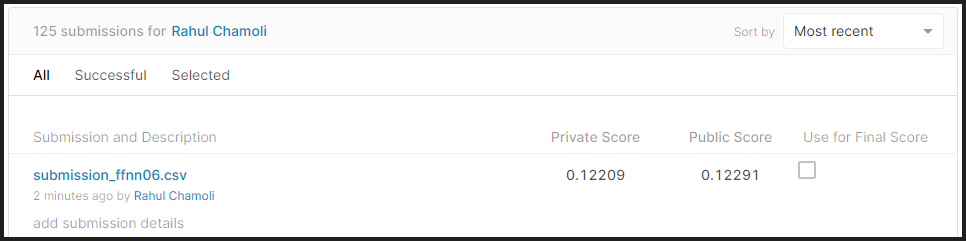

## Simple Average Model

In [ ]:
# loading lightGBM model
lgb_model = lgb.Booster(model_file='finalized_model_lgb_train_2.sav')

# lading xgboost model
xgb_model = xgb.Booster(model_file='finalized_model_xgb_train.sav')

In [ ]:
# creating DMatrix for train, cv and test data
xgb_train = xgb.DMatrix(X_train, label=y_train, feature_names=cols, nthread=-1)
xgb_cv = xgb.DMatrix(X_cv, label=y_cv, feature_names=cols, nthread=-1)
xgb_test = xgb.DMatrix(test_data, feature_names=cols, nthread=-1)

In [ ]:
# predicting from lgb_model
pred_train_lgb = lgb_model.predict(X_train)
# predicting from xgboost model
pred_train_xgb = xgb_model.predict(xgb_train)


# predicting from lgb_model
pred_cv_lgb = lgb_model.predict(X_cv)
# predicting from xgboost model
pred_cv_xgb = xgb_model.predict(xgb_cv)


# predicting from lgb_model
pred_test_lgb = lgb_model.predict(test_data)
# predicting from xgboost model
pred_test_xgb = xgb_model.predict(xgb_test)

In [ ]:
# combined averaged train 
com_train = (pred_train_lgb + pred_train_xgb) / 2

# combined averaged cv
com_cv = (pred_cv_lgb + pred_cv_xgb) / 2

# combined averaged test
com_test = (pred_test_lgb + pred_test_xgb) / 2

In [ ]:
print('Train log-loss', log_loss(y_train, com_train))
print('CV log-loss', log_loss(y_cv, com_cv))

Train log-loss 0.07883471856081796
CV log-loss 0.07951306454211987


In [ ]:
# getting test probabilities
com_test

array([0.0152906 , 0.02263511, 0.0152906 , ..., 0.0152906 , 0.01857474,
       0.0152906 ])

In [ ]:
# loading sample submission file
submit = pd.read_csv('../Data/sample_submission_v2.csv')
# dropping 'is_churn' feature
submit = submit.drop('is_churn', axis=1, inplace=False)
# getting head(top 5 rows)
submit.head()

,msno
0,4n+fXlyJvfQnTeKXTWT507Ll4JVYGrOC8LHCfwBmPE4=
1,aNmbC1GvFUxQyQUidCVmfbQ0YeCuwkPzEdQ0RwWyeZM=
2,rFC9eSG/tMuzpre6cwcMLZHEYM89xY02qcz7HL4//jc=
3,WZ59dLyrQcE7ft06MZ5dj40BnlYQY7PHgg/54+HaCSE=
4,aky/Iv8hMp1/V/yQHLtaVuEmmAxkB5GuasQZePJ7NU4=


In [ ]:
# multiplying probabilities with 0.6
submit['is_churn'] = com_test * 0.60
# getting head(top 5 rows)
submit.head()

,msno,is_churn
0,4n+fXlyJvfQnTeKXTWT507Ll4JVYGrOC8LHCfwBmPE4=,0.009174
1,aNmbC1GvFUxQyQUidCVmfbQ0YeCuwkPzEdQ0RwWyeZM=,0.013581
2,rFC9eSG/tMuzpre6cwcMLZHEYM89xY02qcz7HL4//jc=,0.009174
3,WZ59dLyrQcE7ft06MZ5dj40BnlYQY7PHgg/54+HaCSE=,0.009174
4,aky/Iv8hMp1/V/yQHLtaVuEmmAxkB5GuasQZePJ7NU4=,0.011122


In [ ]:
# saving csv
submit.to_csv('submission_com_avg_model.csv', index=False)

**By using this model I got 0.12660 on public leaderboard as test log-loss and 0.12562 on private leaderboard as test log-loss.**

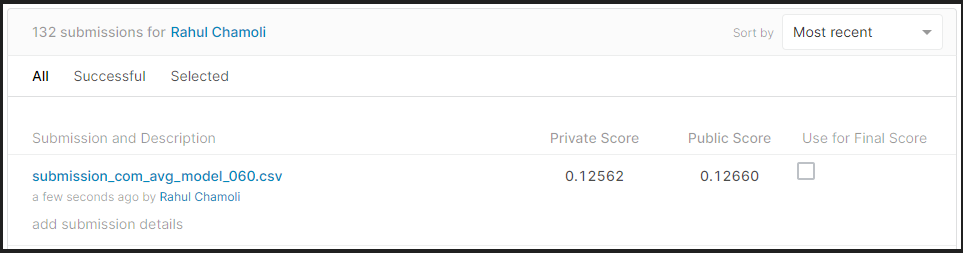